# __Application of a PCM to the argo reference data base__

*Authors*: Andrea Garcia Juan (andrea.garcia.juan@ifremer.fr), Kevin Balem (kevin.balem@ifremer.fr), Cécile Cabanes (cecile.cabanes@ifremer.fr) and Guillaume Maze (gmaze@ifremer.fr)
***

## Description

**The objective of this notebook is to apply a Profile Classification Model (PCM) to the Argo reference database for correcting a specific float using OWC.**

A PCM (__Profile Classification Model__) allows to automatically assemble ocean profiles into clusters according to their vertical structure similarities. It provides an unsupervised, i.e. automatic, method to distinguish profiles from different dynamical regimes of the ocean (e.g. eddies, fronts, quiescent water masses). For more information about the method, see [*Maze et al, Prg.Oc, 2017*](https://www.sciencedirect.com/science/article/pii/S0079661116300714).

The Argo reference profiles are selected using the latitude and longitude scales provided in the OWC configuration file, the PCM is applied and the results are shown in different plots. As output you will obtain a txt file which can be used in **OWC with the PCM option** (available in this repository) to improve the reference profile selection: only profiles in the same class as the float profile will be selected, improving the confidence in the reference profiles used to compute the correction (link to deliverable).

All PCM operations (load, predict) are done using the pyxpcm python software (see documentation at https://pyxpcm.readthedocs.io)

***
This notebook has been developed at the Laboratory for Ocean Physics and Satellite remote sensing, IFREMER, within the framework of the Euro-ArgoRISE project. This project has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement no 824131. Call INFRADEV-03-2018-2019: Individual support to ESFRI and other world-class research infrastructures.

<div>
<center>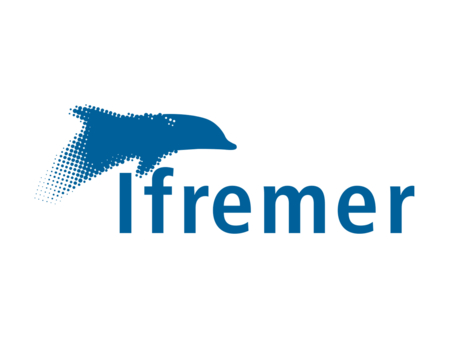 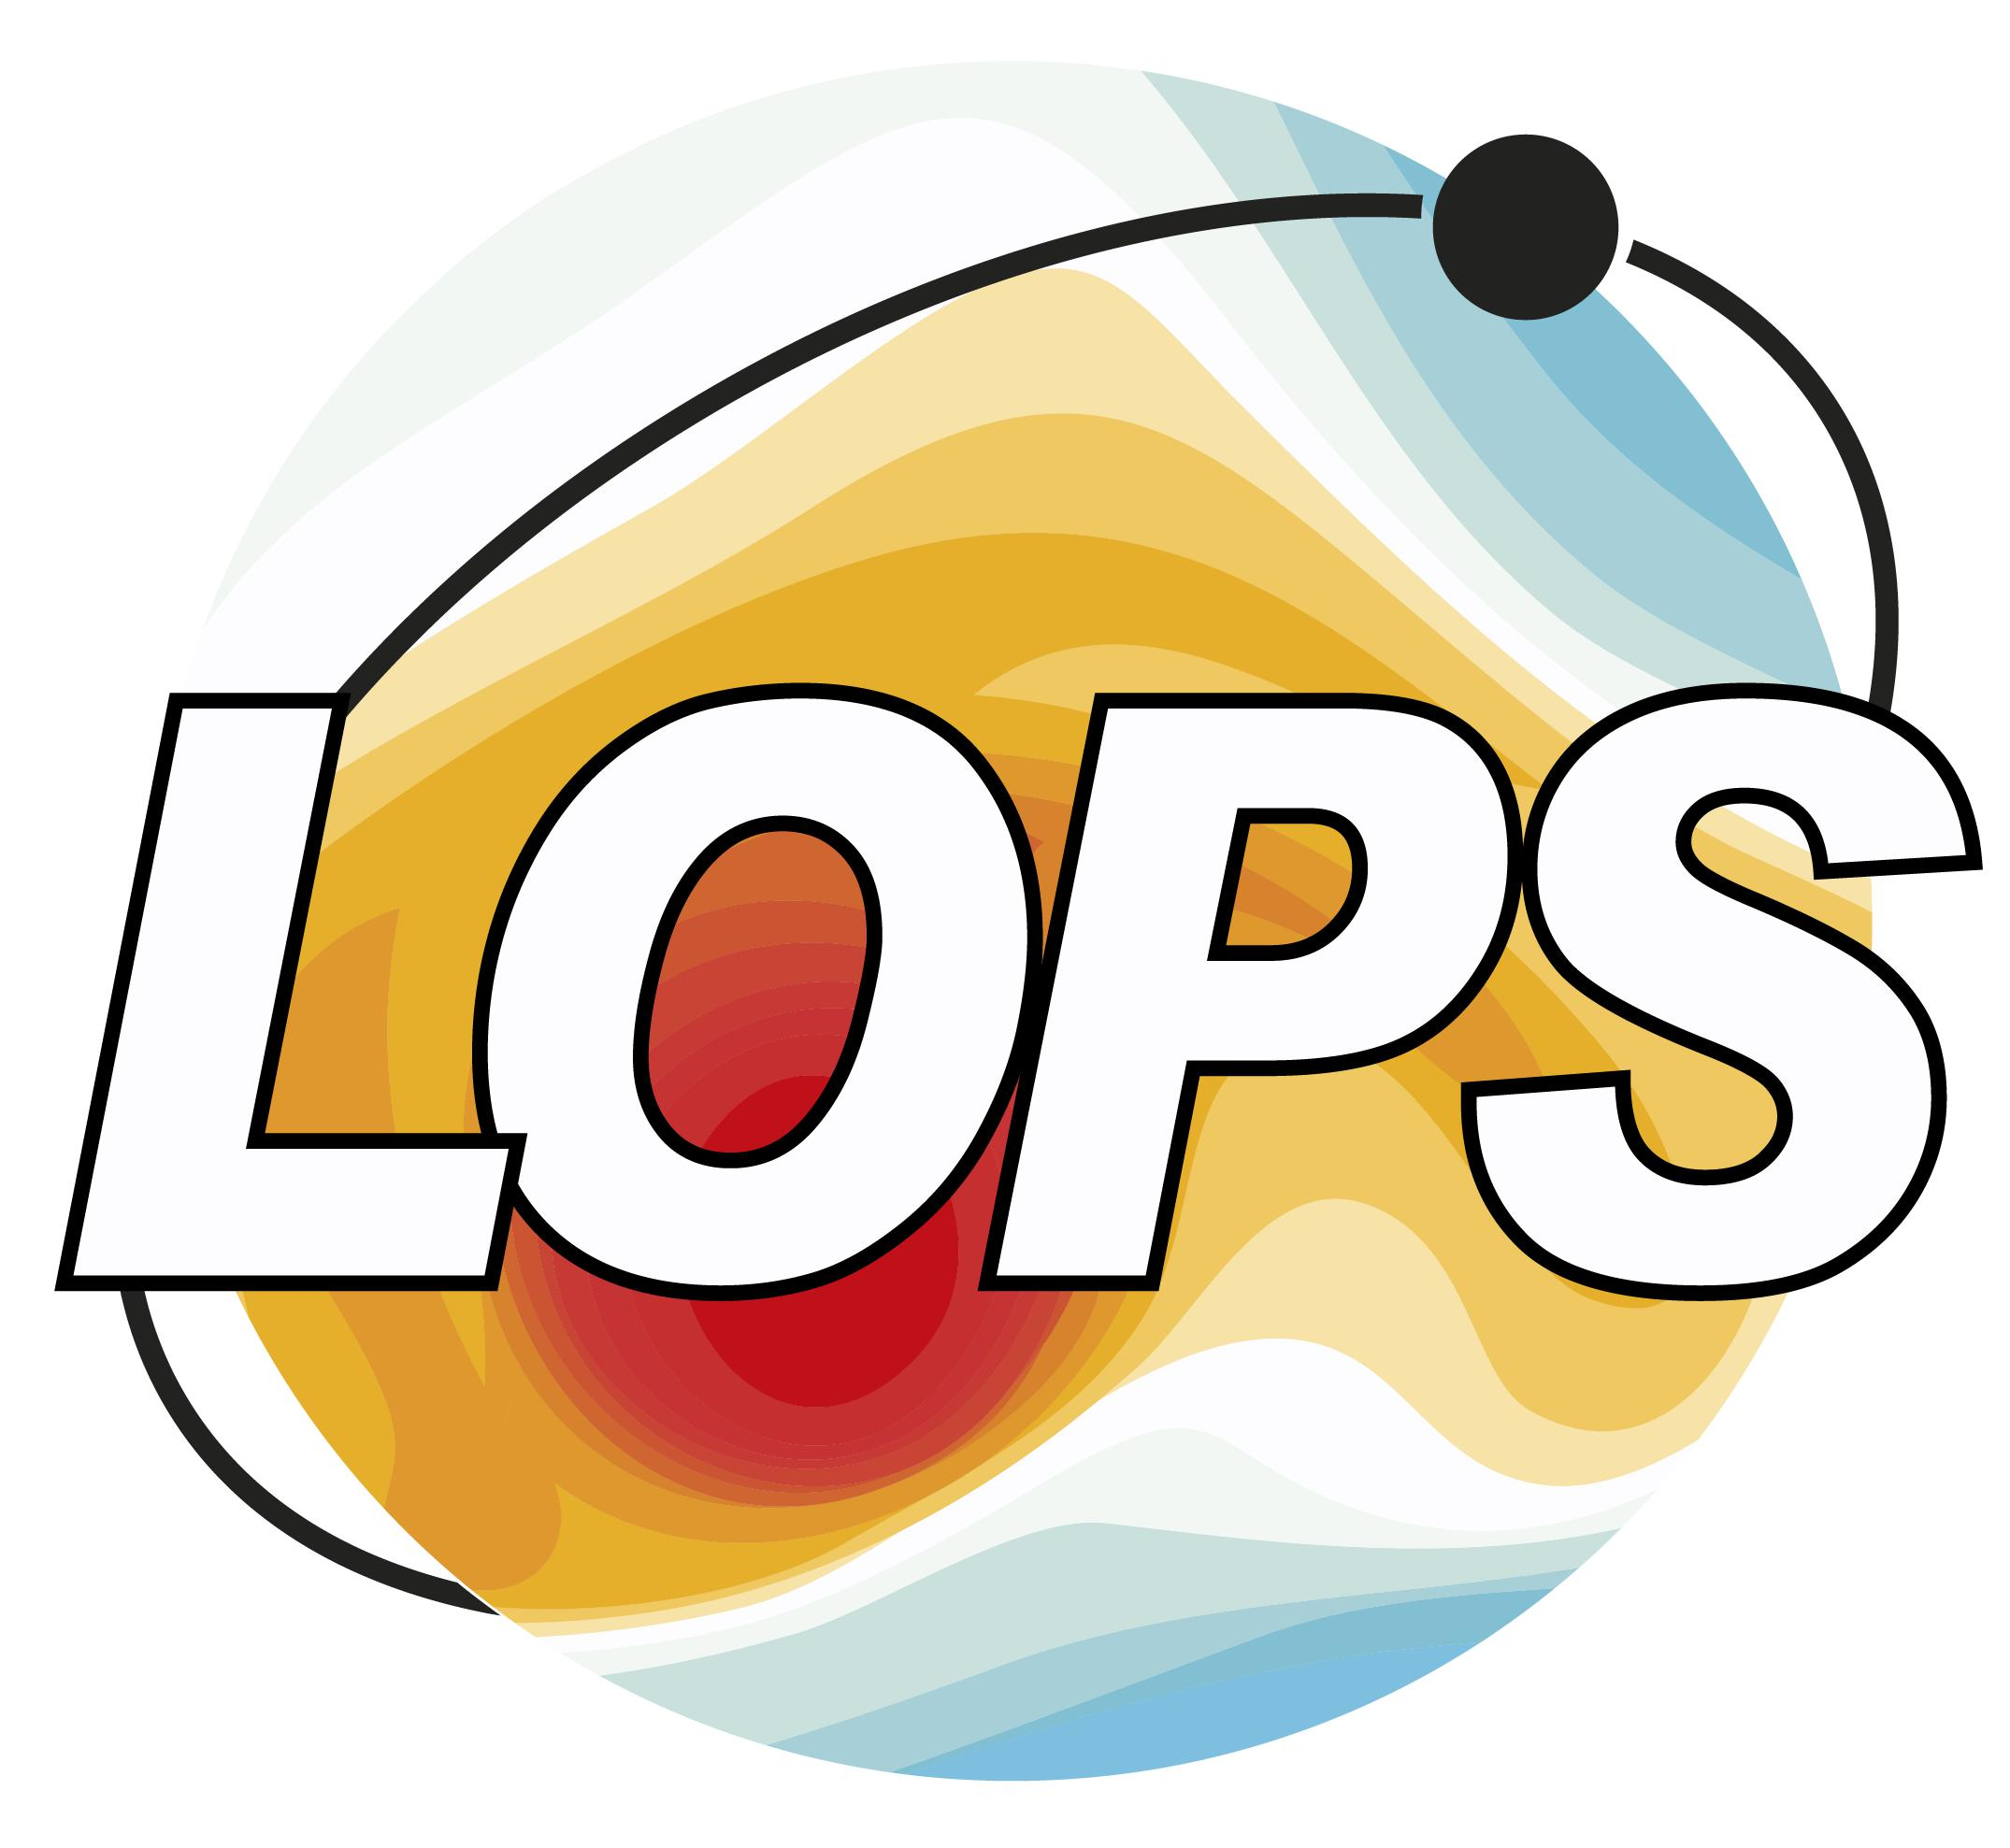 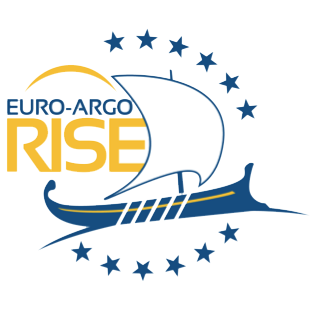</center>
</div>

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma

import pyxpcm
from pyxpcm.models import pcm

import PCM_utils_forDMQC as pcm_utils

import configparser

## User inputs
***

In this section, you should provide the input information: the path to the OWC configuration file, the float reference number, the maximum depth for interpolation and the number of classes.

__Configuration file__

You should provide the path to the **OWC configuration file** (*ow_config.txt*). The information used to select the profiles from the Argo reference database came from this file (``MAPSCALE_LONGITUDE_LARGE`` and ``MAPSCALE_LATITUDE_LARGE``). You can find the most suitable OWC configuration parameters for you float in the DMQC cookbook ([*Cabanes et al, 2021*](https://archimer.ifremer.fr/doc/00678/78994/)). The paths to the Argo reference database directory and the float data are read in the *ow_config.txt* file as well.

In [2]:
config_filename = '/home6/homedir10/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/ow_config.txt'

__Interpolation depth__

The PCM can not deal with NaN values, so the reference dataset is interpolated on standard depth levels and the profiles shallower than the **max_depth**, defined below, are dropped out. A max depth of 1000m can be enough, however you should find a compromise between keeping a sufficient number of reference profiles and having a comprehensive representation of the oceanography in the region. You should also consider the depth of the float profiles: if they are shallower than the max depth, they will be dropped out, and they will not be classified by the PCM. In such cases, a lower value of max depth is recommended.

In [3]:
max_depth = 1000

__Float reference number__

You should provide the **WMO number** of the float you want to correct in OWC. We propose to you 3 examples (explained in the deliverable, link), float 4900136 crossing the Gulf Stream, float 3901928 in the Southern Ocean and float 3901915 in the Agulhas Current. We encourage you to try your own floats!

In [4]:
# Gulf Stream 
float_WMO = 4900136
# Southern ocean
#float_WMO = 3901928
# Agulhas Current
#float_WMO = 3901915
# Galicia
#float_WMO = 6900230

__Number of classes__

The number of classe *K* is a key parameter when designing a PCM. You are invited to try different *K* values to evaluate if the results are coherent with your knowledge of possible ocean regimes in the region. It is also possible to use the BIC notebook (*BIC_plot.ipynb*), which can help you to choose the optimal number of classes *K*.

In [5]:
K=4

## Load argo reference database
***

Important paths are read in the OWC configuration file and data is loaded from the Argo reference database.

__Read OWC configuration file__

In [6]:
with open(config_filename) as f:
    file_content = '[configuration]\n' + f.read()

config_parser = configparser.RawConfigParser(comment_prefixes='%')
config_parser.read_string(file_content)
config = config_parser['configuration']

Three paths are automatically assigned from the OW configuration file:

- ***wmo_boxes_argo.mat*** file path, to determine if you use Argo data, CTD data or both as reference dataset (as in OWC, see [DMQC cookbook](https://archimer.ifremer.fr/doc/00678/78994/))
- path to the **Argo reference database**
- float source directory, where we will find the *.mat* file containing the **float data**. If you have not created the .mat file yet, you can generate it using the last version of argopy (link to argopy and exemple of function).

You can change the automatic paths below, if needed.

In [7]:
wmo_boxes= config['config_directory'] + config['config_wmo_boxes']
ref_path = config['historical_directory']
float_mat_path = config['float_source_directory'] + str(float_WMO)+ '.mat'

__Load argo reference database__

Data is selected in the same way as OWC does: **ellipses** using the longitude and latitude scales defined in the OWC configuration file are constructed around each float profile. The ``map_pv_use`` option makes the selection taking into account the bathymetrie.

In [8]:
ds = pcm_utils.get_refdata(float_mat_path = float_mat_path,  
                 wmo_boxes = wmo_boxes, 
                 ref_path = ref_path,
                 config = config,
                 map_pv_use = 0)

/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7307.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7207.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7506.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7406.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7306.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7206.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7505.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7405.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7305.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7205.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7504.mat
/home5/pharos/argo/DMARGO/OW/VER

In [9]:
print(ds)

<xarray.Dataset>
Dimensions:     (n_pres: 1049, n_profiles: 8793)
Coordinates:
    long        (n_profiles) float64 289.5 289.9 288.9 ... 310.1 313.2 314.1
    lat         (n_profiles) float64 37.31 35.62 37.9 ... 39.79 39.49 39.72
    dates       (n_profiles) datetime64[ns] 2012-01-26T10:51:49 ... 2015-08-1...
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 8787 8788 8789 8790 8791 8792
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1043 1044 1045 1046 1047 1048
Data variables:
    pres        (n_pres, n_profiles) float64 5.0 5.0 5.0 5.0 ... nan nan nan nan
    temp        (n_pres, n_profiles) float64 20.84 19.48 27.21 ... nan nan nan
    sal         (n_pres, n_profiles) float64 36.49 36.53 34.38 ... nan nan nan
    source      (n_profiles) <U46 '1901465_029.BRECKOWENS' ... '4901755_081.B...
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


From this dataset, two dataset are created, the training dataset ``ds_t`` and the prediction dataset ``ds_p``.

## Create training dataset
***

For creating the training dataset `ds_t`, we subsample the initial dataset using a correlation distance, that you will provide below. The PCM will define the different classes using the vertical similarities in `ds_t` profiles. The ocean exhibits spatial correlations that reduce the real information contained in the training dataset. Thus, having a decorrelated dataset to **fit** (train) the PCM is important to obtain meaningful classes.

__Regular sampling__

You should choose the **correlation distance** below.

In [10]:
corr_dist = 50 # in km

In [11]:
ds_t = pcm_utils.get_regulargrid_dataset(ds, corr_dist, season=['all'])

In [12]:
print(ds_t)

<xarray.Dataset>
Dimensions:     (n_pres: 1049, n_profiles: 736)
Coordinates:
    long        (n_profiles) float64 289.0 289.5 289.9 ... 314.9 311.5 313.2
    lat         (n_profiles) float64 37.09 36.14 37.58 ... 37.85 39.9 39.49
    dates       (n_profiles) datetime64[ns] 2006-11-29T13:16:05 ... 2015-08-0...
  * n_profiles  (n_profiles) int64 4 10 16 21 31 33 ... 8772 8774 8780 8789 8791
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1043 1044 1045 1046 1047 1048
Data variables:
    pres        (n_pres, n_profiles) float64 5.0 5.5 4.8 10.0 ... nan nan nan
    temp        (n_pres, n_profiles) float64 23.56 19.66 29.36 ... nan nan nan
    sal         (n_pres, n_profiles) float64 36.47 36.68 36.25 ... nan nan nan
    source      (n_profiles) object '3900580_015.BRECKOWENS' ... '4901755_080...
    mask_s      (n_profiles) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0

__Interpolate to standard levels__

The training dataset `ds_t` is interpolated on standard depth levels and the profiles shallower than the **max_depth** are dropped out.

In [13]:
ds_t = pcm_utils.interpolate_standard_levels(ds_t, std_lev=np.arange(0,max_depth))

/home6/homedir10/perso/agarciaj/EARISE/DMQC-PCM/PCM-design/PCM_utils_forDMQC/data_processing.py:123: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  remapped = xr.apply_ufunc(_regular_interp, z, data, z_regridded, **kwargs)


In [14]:
print(ds_t)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 1000, n_profiles: 679)
Coordinates:
    long               (n_profiles) float64 289.0 289.5 288.3 ... 311.5 313.2
    lat                (n_profiles) float64 37.09 36.14 39.25 ... 39.9 39.49
    dates              (n_profiles) datetime64[ns] 2006-11-29T13:16:05 ... 20...
  * n_profiles         (n_profiles) int64 4 10 21 31 33 ... 8774 8780 8789 8791
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -997 -998 -999
Data variables:
    mask_s             (n_profiles) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    pres               (n_profiles, PRES_INTERPOLATED) float64 5.0 5.0 ... 999.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 36.47 ... 34.97
    source             (n_profiles) object '3900580_015.BRECKOWENS' ... '4901...
    temp               (n_profiles, PRES_INTERPOLATED) float64 23.56 ... 4.788
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...


Quick plot of the profiles in `ds_t`.

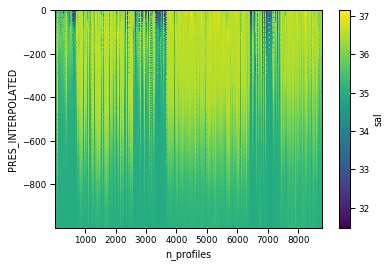

In [15]:
ds_t['sal'].plot(x='n_profiles');

Plot of the **spatial distribution** of the training dataset `ds_t`.

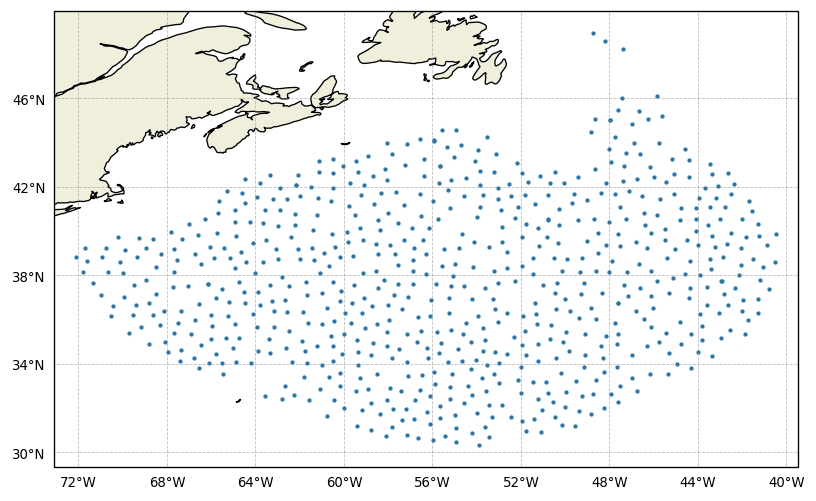

In [16]:
pcm_utils.plot_spatialdist_ds(ds_t, float_WMO, float_traj=False)

## Create prediction dataset
***

All the reference profiles in the initial dataset and the float profiles should be classified. The process in which each profile is assigned to a class is called **prediction**. The prediction dataset `ds_p` is constructed by adding the float profiles to the initial dataset `ds`.

__Add float data to initial dataset__

Float profiles are read in the float source ***.mat*** file used as input by OWC software.

In [ ]:
ds_p = pcm_utils.add_floatdata(float_WMO, float_mat_path, ds)

In [ ]:
print(ds_p)

__Interpolate to standard levels__

The prediction dataset `ds_p` is interpolated on standard depth levels and the profiles shallower than the **max_depth** are dropped out.

In [ ]:
ds_p = pcm_utils.interpolate_standard_levels(ds_p, std_lev=np.arange(0,max_depth))

In [ ]:
print(ds_p)

Plot the **spatial distribution** of the prediction dataset and the **float trajectory**.

In [ ]:
pcm_utils.plot_spatialdist_ds(ds_p, float_WMO, float_traj=True)

## Create and apply a PCM
***

In this section, you can create your own model using the number of classes *K* given as input. Then, the model is trained (__fitted__) to the training dataset and profiles are classified (__predict__) in order to make some useful plots in the next section. You can save your trained model or you can upload a pretrained model and use it.

__Train a new model ...__

*Create model*

In [ ]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']

# pcm feature
z = ds_t[z_dim]
pcm_features = {var_name_mdl[0]: z, var_name_mdl[1]: z}

m = pcm(K=K, features=pcm_features)
m

*Fit model*

In [ ]:
var_name_ds = ['temp', 'sal']
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

m.fit(ds_t, features=features_in_ds, dim=z_dim)
m

Save fitted model

In [ ]:
m.to_netcdf('models/test_model_CTD_3901915_K6_FINAL.nc')

__... or load a pre-trained model__

This can be useful in the case of having scarce CTD data as training dataset. You can fit the model with argo data, save it and make the prediction with the CTD data. Front limits can be more accurate.

In [ ]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']
var_name_ds = ['temp', 'sal']
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

In [ ]:
m = pyxpcm.load_netcdf('models/model_CTD_3901915_K6_FINAL.nc')

__Prediction of class labels__

The trained PCM instance (here called ``m``) contains all the necessary information to classify profiles from the prediction dataset ``ds_p``.
Each profile in ``ds_p`` will be attributed (__predicted__) to one of the PCM classes. A new variable *PCM_LABELS* is created to host this result.

In [ ]:
m.predict(ds_p, features=features_in_ds, inplace = True)
print(ds_p)

__Probability of a profile to be in a class__

As the *pyxpcm* software is using the fuzzy classifier GMM ([Gaussian Mixture Model](https://scikit-learn.org/stable/modules/mixture.html)) by default, it is possible to calculate the probability of a profile to belong to a class, also called __posterior__. This is the first step to determine the robustness of the classification with this PCM, which will be calculated below. A new variable *PCM_POST* is created.

In [ ]:
m.predict_proba(ds_p, features=features_in_ds, dim=z_dim, inplace=True);

__Classes quantiles__

Class vertical structure can be represented using the quantiles of all profiles corresponding to a class. We advise you to calculate at least the __median profile__ and the 5% and 95% quantiles (`q=[0.05, 0.5, 0.95]`) to have a minimal representation of the classes but feel free to add other quantiles if you want. A new variable `outname=var_name_ds + '_Q'` is added to the dataset.

In [ ]:
ds_p = ds_p.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds[0], outname=var_name_ds[0] + '_Q', keep_attrs=True, inplace=True)
ds_p = ds_p.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds[1], outname=var_name_ds[1] + '_Q', keep_attrs=True, inplace=True)

__Robustness__

The classification robustness is a scaled version of the __probability__ of a profile to belong to a class (i.e. the posteriors) so that the value range is more appropriate to assess the **robustness** of a classification.
A 0 value indicates the PCM is totally unsure of the classification result (all classes are equiprobable), while values close to 1 indicate the PCM is highly confident of the result.
Note that this does not prevail over the scientific meaning of the classification, but rather indicates the ability of the PCM to attribute a profile to a specific class with confidence.

Two new variables are added to the dataset: *PCM_ROBUSTNESS* and *PCM_ROBUSTNESS_CAT*. The 2nd variable is categorical and is based on the IPCC likelihood scale:

| Robustness range | Category          |
|------------------|-------------------|
| 0-33%            | Unlikely          |
| 33%-66%          | As likely as not  |
| 66%-90%          | Likely            |
| 90%-99%          | Very likely       |
| 99%-100%         | Virtually certain |

In [ ]:
ds_p.pyxpcm.robustness(m, inplace=True)
ds_p.pyxpcm.robustness_digit(m, inplace=True)

In [ ]:
print(ds_p)

## Classification plots
***

Plots are created using the *Plotter* class, which is instantiated below. Plots include the **vertical structure** and the **spatial and temporal distribution** of classes. These plots will allow you to determine if classes show a spatial or temporal coherence you are looking for to differentiate the reference profiles.

Figures are automatically saved in the *figures/* folder. You can change figures names using the ``save_fig`` option in each plotting function.

Please, feel free to change plot options if you need it.

In [ ]:
P = pcm_utils.Plotter(ds_p, m, coords_dict= {'latitude': 'lat', 'longitude': 'long', 'time': 'dates'})
P.data_type = 'profiles'

#### __Vertical structure of classes__

The graphic representation of quantile profiles reveals the vertical structure of each class. 
These different vertical structures are the foundation of the PCM, the "distance" of a profile to each of the typical vertical structures controls the classification outcome. 
The median profiles will give you the best idea of the __typical profile__ of a class and the other quantiles, the possible __spread__ of profiles within a class. It is with the spread that you can determine if a class has captured a homogeneous water mass (small spread) or a layer with gradients (large spread, like a thermocline for instance).

*Temperature*

In [ ]:
P.vertical_structure(q_variable = var_name_ds[0] + '_Q', sharey=True, xlabel='Temperature (°C)', 
                     save_fig='figures/temperature_quantiles.jpg')

*Salinity*

In [ ]:
P.vertical_structure(q_variable = var_name_ds[1] + '_Q', sharey=True, xlabel='Salinity (PSU)', 
                     save_fig='figures/salinity_quantiles.jpg')

Quantiles can also be plotted __together__ to highlight differences between classes. Using the `plot_q` option you can choose the quantiles you want to plot together.

*Temperature*

In [ ]:
P.vertical_structure_comp(q_variable = var_name_ds[0] + '_Q', plot_q= 'all', xlabel='Temperature (°C)', 
                          save_fig='figures/temperature_quantiles_comp.jpg')

*Salinity*

In [ ]:
P.vertical_structure_comp(q_variable = var_name_ds[1] + '_Q', plot_q= 'all', xlabel='Salinity (PSU)', 
                          save_fig='figures/salinity_quantiles_comp.jpg')

#### __Spatial distribution of classes__

You can also plot the PCM labels in a map to analyze the spatial coherence of classes. The spatial information (coordinates) of profiles is not used to fit the model, so spatial coherence appears naturally, revealing vertical structure similarities between different areas of the ocean. You can use this figure to determine if your classification is taking into account the **dynamical regimes** of the ocean you want to differentiate (e.g. eddies, fronts, quiescent water masses). If it is not the case, you can try with a different number of classes *K*.

In [ ]:
P.spatial_distribution(lonlat_grid =[8,8],
                       save_fig='figures/spatial_distribution.jpg')

#### __Float profiles classification__

In this section, you can take a look at the classification of the float profiles.

***Float trajectory classes***

Float profiles are represented in the space and a colorbar indicates its class.

In [ ]:
P.float_traj_classes(save_fig='figures/float_profiles_classes.jpg')

***Float cycles probability***

Probability of each float profile to belong to its class. Together with the robustness figure can give you an idea of the **suitability** of the classification in the float profiles.

In [ ]:
P.float_cycles_prob(var_name='PCM_POST',
                    save_fig='figures/float_profiles_probability.jpg')

***Float cycles robustness***

Robustness is a scaled __probability__ of a profile to belong to a class. 

In [ ]:
P.float_cycles_prob(var_name='PCM_ROBUSTNESS_CAT',
                    save_fig='figures/float_profiles_robustness.jpg')

#### __Classes pie chart__

Here you can plot a pie chart showing the percentage of profiles belonging to each class and the number of classified profiles.

In [ ]:
P.pie_classes(save_fig = 'figures/classes_pie_chart.jpg')

#### __Temporal representation__ 

The bar plots below represent the percentage of profiles in each class by month and by season. These plots can unfold underlying **temporal coherence** between classes: some classes can be more important in summer or in winter periods. Coherence is revealed naturally by ocean structures since time was not used to fit the PCM model.

Bar plot by __month__

In [ ]:
P.temporal_distribution(time_bins = 'month',
                        save_fig = 'figures/temporal_distribution_months.jpg')

Bar plot by __season__

In [ ]:
P.temporal_distribution(time_bins = 'season',
                        save_fig = 'figures/temporal_distribution_season.jpg')

## Generate output file
***

Finally, a *.txt* file including a list of reference profile sources, coordinates and class labels is created. It can be used in the OWC software version including the **PCM option** to select profiles in the same class as float profile to compute the OWC calibration. You can change the file name below.

In [ ]:
matrix_txt = np.stack(('"'+ ds_p['source'].values + '"', ds_p['lat'].values, ds_p['long'].values, ds_p['PCM_LABELS'].values), axis=1)
header = 'source lat long PCM_LABELS'

f= open("output_files/test_PCM_classes_4900136_argo_k4.txt","w+")
np.savetxt(f, matrix_txt, fmt=['%s', '%.3f', '%.3f', '%.1f'], header=header)
f.close() 